# Analiza zbioru danych "US births (2018)"

###### Projekt zaliczeniowy - Podstawy Uczenia Maszynowego
###### Aleksandra Mincberg,  Maciej Knera, Adrian Kurkowski

## Cel projektu
Celem projektu jest analiza zbioru danych dotyczącego urodzeń w Stanach Zjednoczonych w 2018 roku. 
W poszczególnych elementach analizy skupiliśmy się na sprawdzeniu, czy za pomocą uczenia maszynowego można przewidzieć:
* metodę narodzin dziecka
* wystąpienie ryzyka zagrożenia ciąży
* masę dziecka przy narodzinach - co jest zadaniem dla tego zbioru danych na stronie kaggle.com

## Zbiór danych oraz ich obróbka
Zbiór danych składa się z 3,8 miliona rekordów i 55 kolumn. Jest dostępny do wglądu i pobrania na stronie https://www.kaggle.com/des137/us-births-2018.

Opis kolumn na podstawie "User Guide to the 2018 Natality Public Use File", dostępne do pobrania:
https://www.cdc.gov/nchs/data_access/vitalstatsonline.htm

Na początku importujemy niezbędne biblioteki do wczytania zbioru danych.
Zmienna cols_to_keep zawiera nazwy wszystkich kolumn, jakie będziemy wczytywać.

In [125]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")

cols_to_keep = ['ATTEND', 'BFACIL', 'BMI', 'CIG_0', 'DBWT', 
                'DLMP_MM', 'DLMP_YY', 'DMAR', 'DOB_MM', 'DOB_TT',
                'DOB_WK', 'DWgt_R', 'FAGECOMB', 'FRACE6', 'MAGER',
                'MRAVE6', 'M_Ht_In', 'NO_INFEC', 'NO_RISKS', 'PRIORDEAD',
                'PRIORLIVE', 'PRECARE', 'PREVIS', 'PWgt_R', 'RDMETH_REC',
                'RF_CESARN', 'SEX', 'WTGAIN']

Ze względu na dużą ilość danych, zmieniamy typy danych, aby ograniczyć ilość pamięci potrzebnej do działania na zbiorze.
Przykładowo, dane z zakresu 1 do 9 (jak kolumna "ATTEND") wymagają jedynie uint8, ale kolumna zawierająca dane z zakresu 227 do 9999 (kolumna DBWT) wymaga już uint16.

In [126]:
dtypes = \
    {'ATTEND': np.uint8, 'BFACIL': np.uint8, 'BMI': np.float32, 'CIG_0': np.uint8, 'DBWT': np.uint16,
     'DLMP_MM': np.uint8, 'DLMP_YY': np.uint16, 'DMAR': np.uint8, 'DOB_MM': np.uint8, 'DOB_TT': np.uint16,
     'DOB_WK': np.uint8, 'DWgt_R': np.uint16, 'FAGECOMB': np.uint8, 'FRACE6': np.uint8, 'MAGER': np.uint8,
     'MRAVE6': np.uint8, 'M_Ht_In': np.uint8, 'NO_INFEC': np.uint8, 'NO_RISKS': np.uint8, 'PRIORDEAD': np.uint8,
     'PRIORLIVE': np.uint8, 'PRECARE': np.uint8, 'PREVIS': np.uint8, 'PWgt_R': np.uint16, 'RDMETH_REC': np.uint8,
     'RF_CESARN': np.uint8, 'SEX': np.uint8, 'WTGAIN': np.uint8}

Wczytujemy dane do dataframe. Aby ułatwić pracę na kolumnie "płeć" (SEX), zmieniamy jej wartości z ('M', 'F') do (0, 1).

In [127]:
data = pd.read_csv("US_births(2018).csv", delimiter=',', usecols=cols_to_keep, dtype=None)
data.loc[data['SEX'] == 'M', 'SEX'] = 0
data.loc[data['SEX'] == 'F', 'SEX'] = 1

Za pomocą regexa zamieniamy wartość wszystkich pustych pól na 99 oraz ustawiamy typ danych za pomocą "df.astype()".
W dokumentacji zbioru możemy przeczytać, że nieznane wartości najczęściej wyrażają się za pomocą liczb 9, 99 lub 9999. Korzystając z tej informacji, usuwamy właśnie te rekordy, które zawierą
wyżej wymienione liczby. Oczywiście sprawdzamy wcześniej czy można to zrobić bez utraty ważnych rekordów.

In [128]:
data = data.replace(r'^\s*$', 99, regex=True)
data = data.astype(dtypes)

for column in range(0, len(data.columns)):
    data = data[data[data.columns[column]] != 99]
for column in ['ATTEND', 'BFACIL', 'DMAR', 'DOB_WK', 'FRACE6',
               'MRAVE6', 'NO_INFEC', 'NO_RISKS', 'RDMETH_REC']:
    data = data[data[column] != 9]
for column in ['DOB_TT', 'DLMP_YY', 'DBWT']:
    data = data[data[column] != 9999]

In [129]:
df = data.copy()

Poniżej znajduje się opis wybranych kolumn:

**ATTEND** - Asystent przy porodzie.<br>
**Wartości:**<br>
1 - doktor medycyny,<br>
2 - doktor osteopatii,<br>
3 - certyfikowana położna,<br>
4 - inna położna,<br>
5 - inne,<br>
9 - nieokreślone lub niepodane.<br>

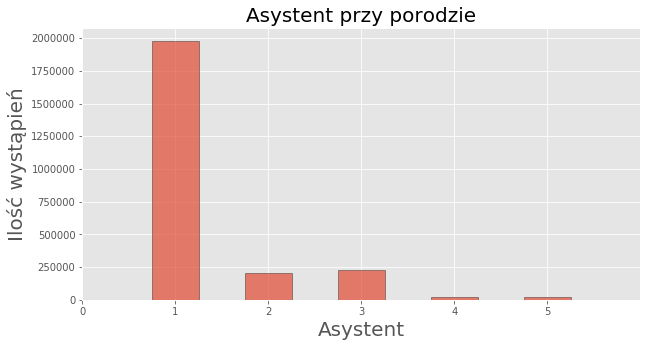

In [130]:
bins = np.arange(0,6) + 0.5
df.ATTEND.plot(kind='hist', edgecolor='black', alpha=.7, rwidth=0.5, bins=bins, figsize = (10,5))
plt.title('Asystent przy porodzie', size=20)
plt.xlabel('Asystent', size=20)
plt.ylabel('Ilość wystąpień', size=20)
plt.xlim((0, 6))
plt.xticks(bins - 0.5);

**BFACIL** - miejsce urodzenia.<br>
**Wartości:**<br>
1 - szpital,<br>
2 - centrum porodowe,<br>
3 - dom(zamierzone),<br>
4 - dom(niezamierzone),<br>
5 - dom(niewiadomo, czy zamierzone),<br>
6 - klinika/biuro doktora,<br>
7 - inne,<br>
9 - nieznane.

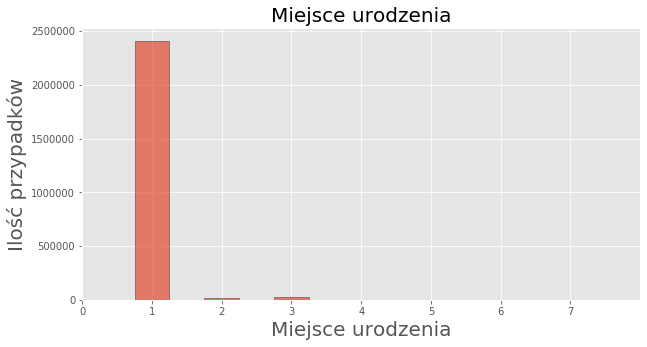

In [131]:
bins = np.arange(0,8) + 0.5
df.BFACIL.plot(kind='hist', edgecolor='black', alpha=.7, rwidth=0.5, bins=bins, figsize=(10,5))
plt.title('Miejsce urodzenia', size=20)
plt.xlabel('Miejsce urodzenia', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((0, 8))
plt.xticks(bins - 0.5);

**BMI** - wartość BMI matki.<br>
**Wartości:** [13, 99]<br>
99 - nieznane.

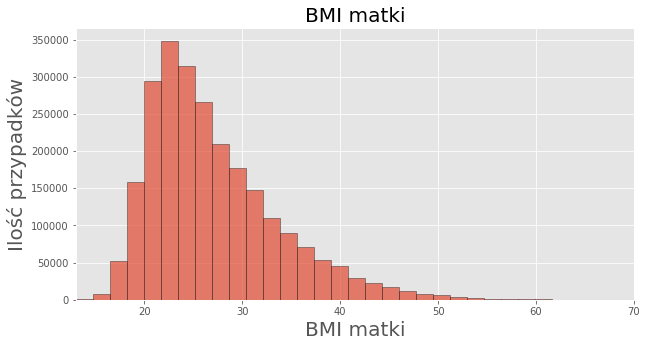

In [132]:
df.BMI.plot(kind='hist', edgecolor='black', alpha=.7, rwidth=1, bins=50, figsize = (10,5))
plt.title('BMI matki', size=20)
plt.xlabel('BMI matki', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((13, 70));

**CIG_0** - dzienne spożycie papierosów przed rozpoczęciem ciąży.<br>
**Wartości:** [0, 98]<br>
99 - nieznane.

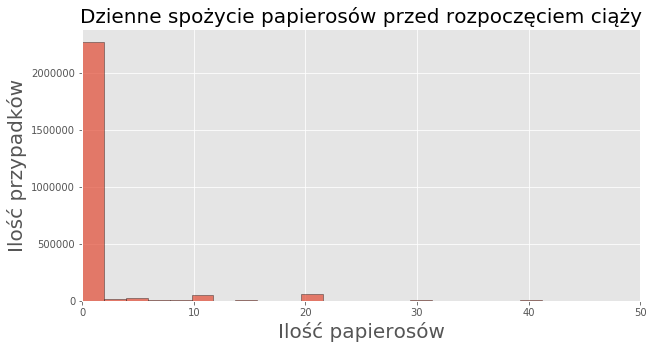

In [133]:
df.CIG_0.plot(kind='hist', edgecolor='black', alpha=.7, rwidth=1, bins=50, figsize = (10,5))
plt.title('Dzienne spożycie papierosów przed rozpoczęciem ciąży', size=20)
plt.xlabel('Ilość papierosów', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((0, 50));

**DBWT** - waga noworodka wyrażona w gramach.<br>
**Wartości:** [227, 8165]<br>
9999 - nieznane.

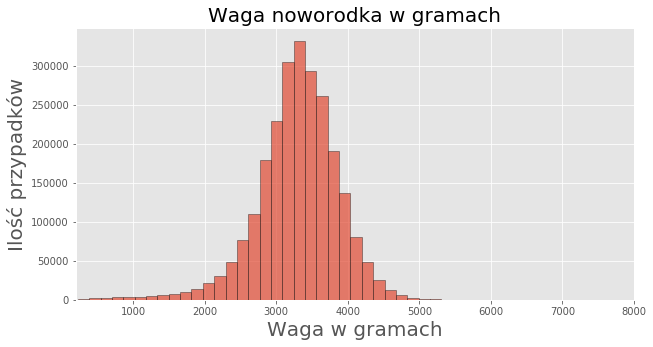

In [134]:
df.DBWT.plot(kind='hist', edgecolor='black',alpha=.7, rwidth=1, bins=50, figsize = (10,5))
plt.title('Waga noworodka w gramach', size=20)
plt.xlabel('Waga w gramach', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((200, 8000));

**DLMP_YY** - rok ostatniej miesiączki.<br>
**Wartości:** [2016, 2018]<br>
9999 - nieznane.

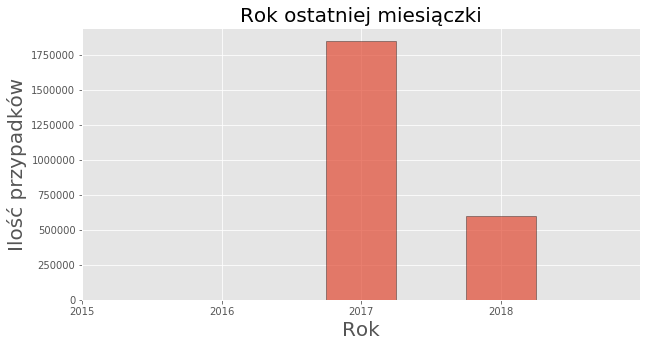

In [135]:
bins = np.arange(2015,2019) + 0.5
df.DLMP_YY.plot(kind='hist', edgecolor='black', alpha=.7, rwidth=0.5, bins=bins, figsize = (10,5))
plt.title('Rok ostatniej miesiączki', size=20)
plt.xlabel('Rok', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((2015, 2019))
plt.xticks(bins - 0.5);

**DMAR** - status cywilny matki.<br>
**Wartości:**<br>
1 - zamężna,<br>
2 - niezamężna.<br>

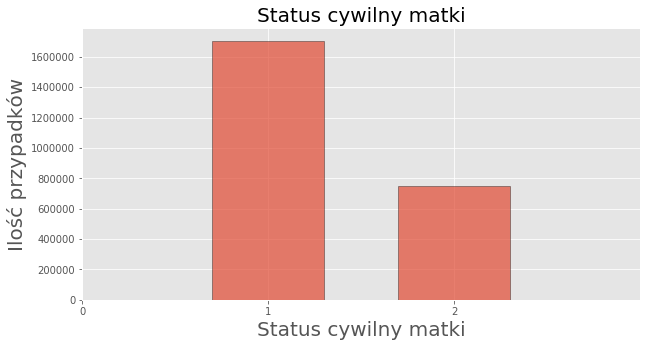

In [136]:
bins = np.arange(0,3) + 0.5
df.DMAR.plot(kind='hist', edgecolor='black',alpha=.7, rwidth=.6, bins=bins, figsize = (10,5))
plt.title('Status cywilny matki', size=20)
plt.xlabel('Status cywilny matki', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((0, 3))
plt.xticks(bins - 0.5);

**DOB_MM** - miesiąc urodzenia.<br>
**Wartości:** dyskretne od 1 do 12.<br>

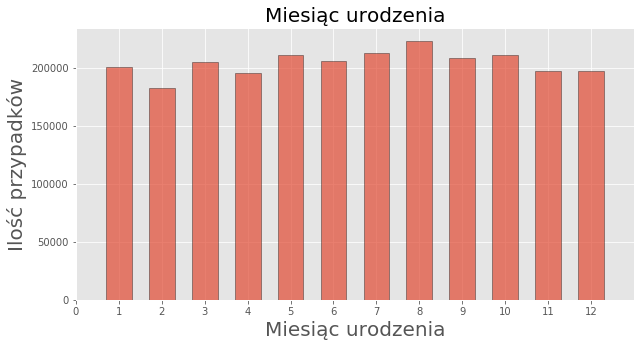

In [137]:
bins = np.arange(0,13) + 0.5
df.DOB_MM.plot(kind='hist', edgecolor='black',alpha=.7, rwidth=.6, bins=bins, figsize = (10,5))
plt.title('Miesiąc urodzenia', size=20)
plt.xlabel('Miesiąc urodzenia', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((0, 13))
plt.xticks(bins - 0.5);

**DOB_TT** - czas urodzenia reprezentujący godzinę i minutę HHMM.<br>
**Wartości:** [0, 2400]<br>
9999 - nieznane.

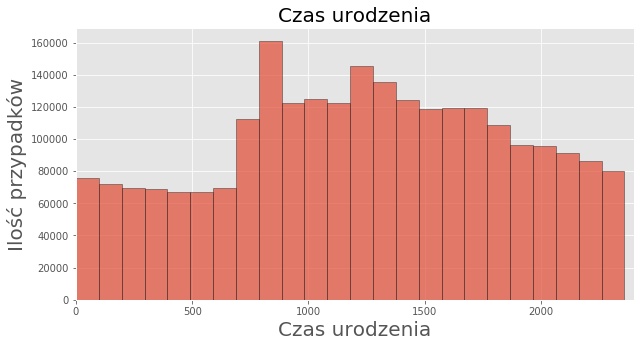

In [138]:
df.DOB_TT.plot(kind='hist', edgecolor='black',alpha=.7, rwidth=1, bins=24, figsize = (10,5))
plt.title('Czas urodzenia', size=20)
plt.xlabel('Czas urodzenia', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((0, 2400));

**DOB_WK** - dzień tygodnia urodzenia.<br>
**Wartości:** dyskretne od 1 do 7<br>

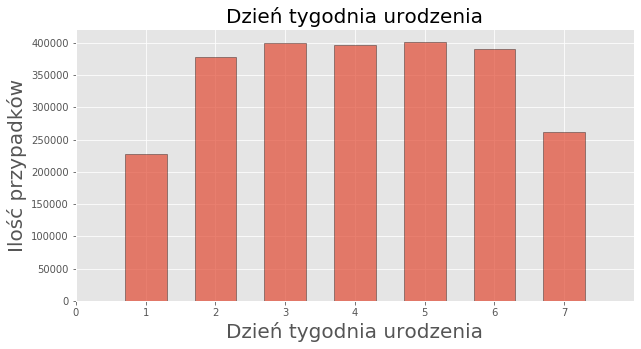

In [139]:
bins = np.arange(0,8) + 0.5
df.DOB_WK.plot(kind='hist', edgecolor='black',alpha=.7, rwidth=.6, bins=bins, figsize = (10,5))
plt.title('Dzień tygodnia urodzenia', size=20)
plt.xlabel('Dzień tygodnia urodzenia', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((0, 8))
plt.xticks(bins - 0.5);

**DWgt_R** - waga kobiety w momencie porodu.<br>
**Wartości:** [100, 400]<br>
999 - nieznane.

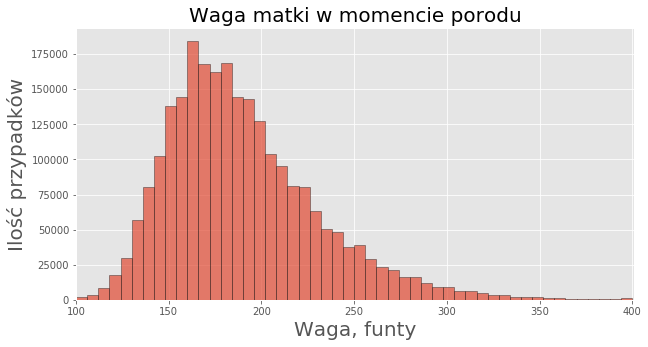

In [140]:
df.DWgt_R.plot(kind='hist', edgecolor='black',alpha=.7, rwidth=1, bins=50, figsize = (10,5))
plt.title('Waga matki w momencie porodu', size=20)
plt.xlabel('Waga, funty', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((100, 401));

**FAGECOMB** - wiek ojca.<br>
**Wartości:** [11, 99]<br>
99 - nieznane.

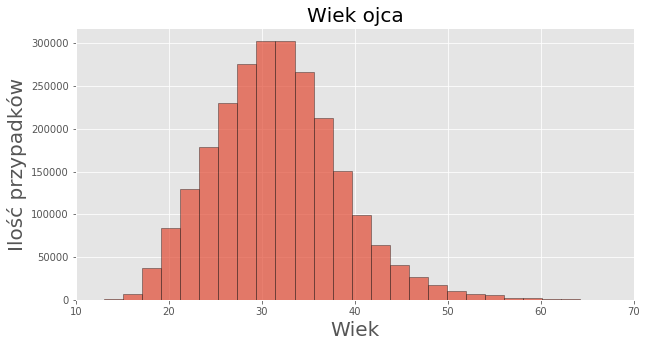

In [141]:
df.FAGECOMB.plot(kind='hist', edgecolor='black',alpha=.7, rwidth=1, bins=40, figsize = (10,5))
plt.title('Wiek ojca', size=20)
plt.xlabel('Wiek', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((10, 70));

**FRACE6** – rasa ojca.<br>
**Wartości:**<br>
1 – biała(wyłącznie),<br>
2 - czarna(wyłącznie),<br>
3 - rdzenni Amerykanie i rdzenni mieszkańcy Alaski,<br>
4 - azjatycka(wyłącznie),<br>
5 – rdzenni mieszkańcy Hawajów i innych wysp Pacyfiku,<br>
6 – więcej niż jedna rasa,<br>
9 – nieznana lub niepodana.

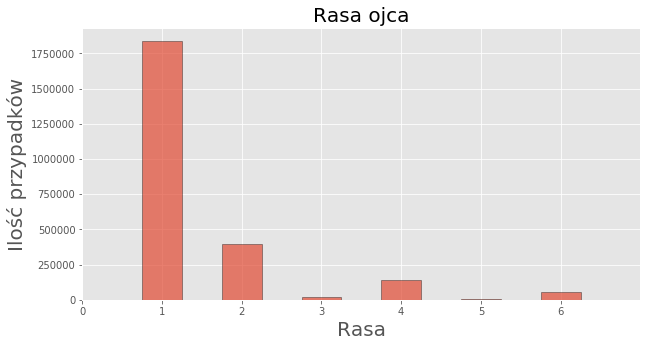

In [142]:
bins = np.arange(0,7) + 0.5
df.FRACE6.plot(kind='hist', edgecolor='black', alpha=.7, rwidth=0.5, bins=bins, figsize = (10,5))
plt.title('Rasa ojca', size=20)
plt.xlabel('Rasa', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((0, 7))
plt.xticks(bins - 0.5);

**MAGER** - wiek matki.<br>
**Wartości:** [12, 50]<br>

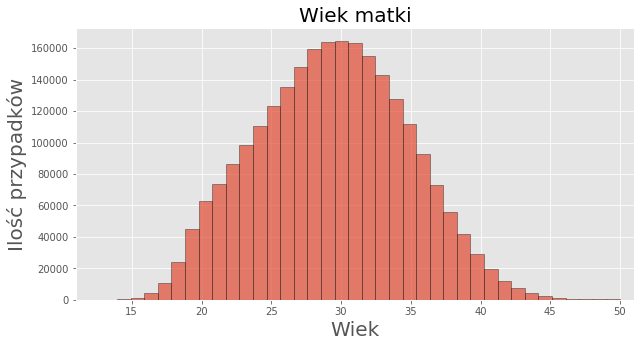

In [143]:
df.MAGER.plot(kind='hist', edgecolor='black',alpha=.7, rwidth=1, bins=39, figsize = (10,5))
plt.title('Wiek matki', size=20)
plt.xlabel('Wiek', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((11, 51));

**MRAVE6** – rasa matki.<br>
**Wartości:**<br>
1 – biała(wyłącznie),<br>
2 - czarna(wyłącznie),<br>
3 - rdzenni Amerykanie i rdzenni mieszkańcy Alaski,<br>
4 - azjatycka(wyłącznie),<br>
5 – rdzenni mieszkańcy Hawajów i innych wysp Pacyfiku,<br>
6 – więcej niż jedna rasa,<br>
9 – nieznana lub niepodana.

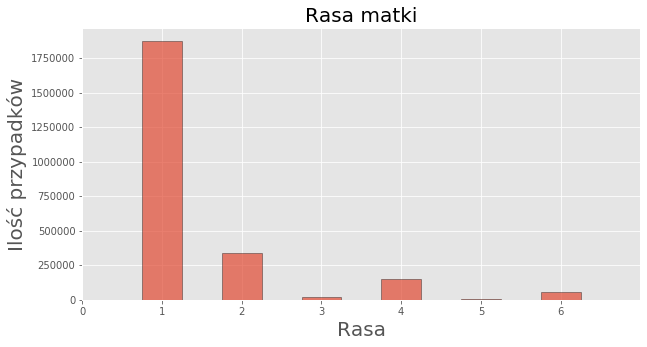

In [144]:
bins = np.arange(0,7) + 0.5
df.MRAVE6.plot(kind='hist', edgecolor='black', alpha=.7, rwidth=0.5, bins=bins, figsize = (10,5))
plt.title('Rasa matki', size=20)
plt.xlabel('Rasa', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((0, 7))
plt.xticks(bins - 0.5);

**M_Ht_In** - wysokość matki w calach.<br>
**Wartości:** [30, 99]<br>
99 - nieznane.

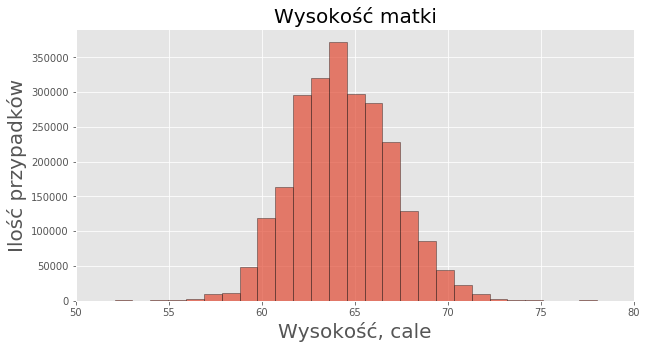

In [145]:
df.M_Ht_In.plot(kind='hist', edgecolor='black',alpha=.7, rwidth=1, bins=50, figsize = (10,5))
plt.title('Wysokość matki', size=20)
plt.xlabel('Wysokość, cale', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((50, 80));

**NO_INFEC** - brak odnotowanych infekcji.<br>
**Wartości:**<br>
0 - fałsz $\rightarrow$ odnotowano wystąpienie infekcji,<br>
1 - prawda $\rightarrow$ nie odnotowano wystąpienia infekcji,<br>
9 - nieznane.

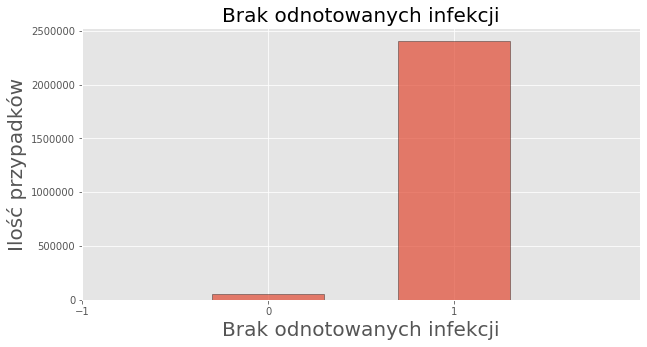

In [146]:
bins = np.arange(-1,2) + 0.5
df.NO_INFEC.plot(kind='hist', edgecolor='black',alpha=.7, rwidth=.6, bins=bins, figsize = (10,5))
plt.title('Brak odnotowanych infekcji', size=20)
plt.xlabel('Brak odnotowanych infekcji', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((-1, 2))
plt.xticks(bins - 0.5);

**NO_RISKS** - brak odnotowanych czynników ryzyka.<br>
**Wartości:**<br>
0 - fałsz  $\rightarrow$ ciąża zagrożona,<br>
1 - prawda $\rightarrow$ ciąża niezagrożona,<br>
9 - nieznane.

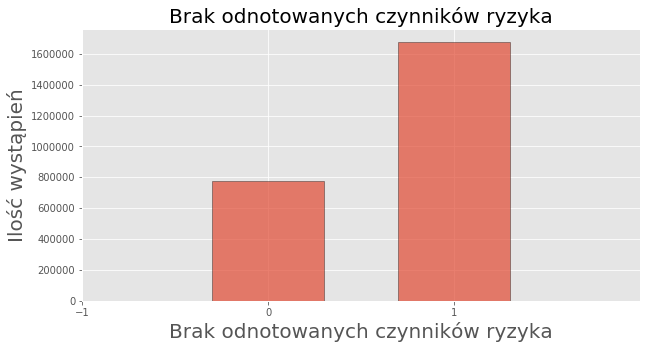

In [147]:
bins = np.arange(-1,2) + 0.5
df.NO_RISKS.plot(kind='hist', edgecolor='black',alpha=.7, rwidth=.6, bins=bins, figsize = (10,5))
plt.title('Brak odnotowanych czynników ryzyka', size=20)
plt.xlabel('Brak odnotowanych czynników ryzyka', size=20)
plt.ylabel('Ilość wystąpień', size=20)
plt.xlim((-1, 2))
plt.xticks(bins - 0.5);

**PRECARE** - miesiąc rozpoczęcia opieki prenatalnej.<br>
**Wartości:** dyskretne od 1 do 9.<br>
99 - nieznane.

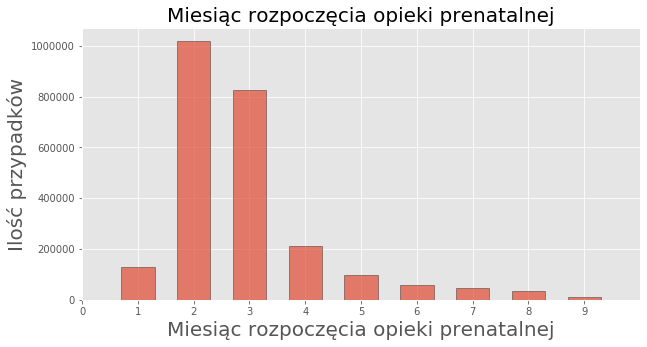

In [148]:
bins = np.arange(0,10) + 0.5
df.PRECARE.plot(kind='hist', edgecolor='black',alpha=.7, rwidth=.6, bins=bins, figsize = (10,5))
plt.title('Miesiąc rozpoczęcia opieki prenatalnej', size=20)
plt.xlabel('Miesiąc rozpoczęcia opieki prenatalnej', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((0, 10))
plt.xticks(bins - 0.5);

**PREVIS** - ilość wizyt prenatalnych.<br>
**Wartości:** [0, 99]<br>
99 - nieznane.

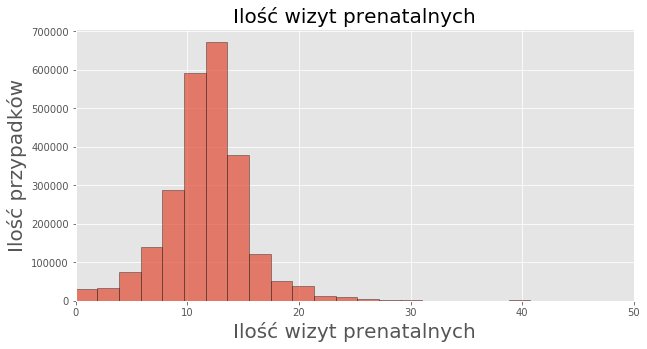

In [149]:
df.PREVIS.plot(kind='hist', edgecolor='black',alpha=.7, rwidth=1, bins=50, figsize = (10,5))
plt.title('Ilość wizyt prenatalnych', size=20)
plt.xlabel('Ilość wizyt prenatalnych', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((0, 50));

**PWgt_R** - waga matki przed rozpoczęciem ciąży.<br>
**Wartości:** [75, 375]<br>
999 - nieznane.

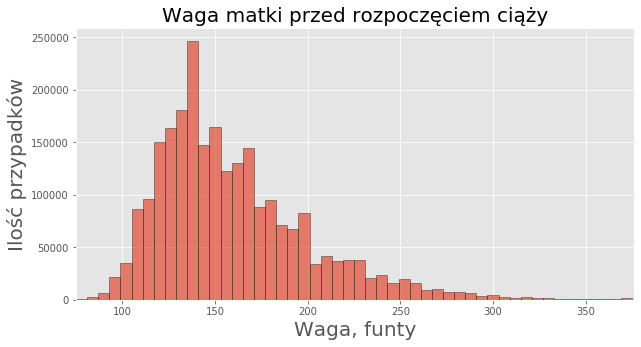

In [150]:
df.PWgt_R.plot(kind='hist', edgecolor='black',alpha=.7, rwidth=1, bins=50, figsize = (10,5))
plt.title('Waga matki przed rozpoczęciem ciąży', size=20)
plt.xlabel('Waga, funty', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((75, 376));

**RDMETH_REC** - metoda porodu. <br>
**Wartości:**<br>
1 - naturalna,<br>
2 - naturalna, z wcześniejszym cesarskim cięciem,<br>
3 - cesarskie cięcie (po raz pierwszy),<br>
4 - cesarskie cięcie (powtórzenie),<br>
5 - naturalna (wcześniejsza metoda porodu nieznana),<br>
6 - cesarskie cięcie (wcześniejsza metoda porodu nieznana),<br>
9 - nieznane.

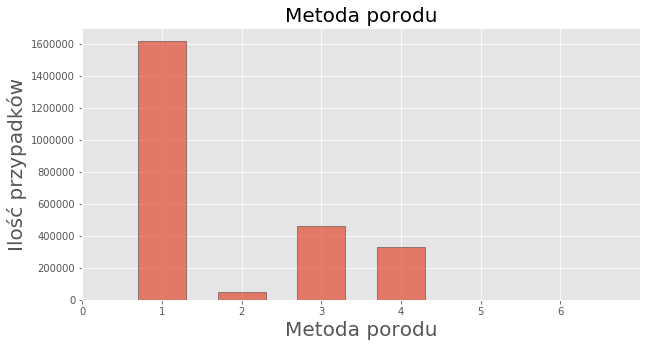

In [151]:
bins = np.arange(0,7) + 0.5
df.RDMETH_REC.plot(kind='hist', edgecolor='black',alpha=.7, rwidth=.6, bins=bins, figsize = (10,5))
plt.title('Metoda porodu', size=20)
plt.xlabel('Metoda porodu', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((0, 7))
plt.xticks(bins - 0.5);

**RF_CESARN** - ilość wcześniejszych cesarskich cięć.<br>
**Wartości:** [0, 30]<br>
99 - nieznane.

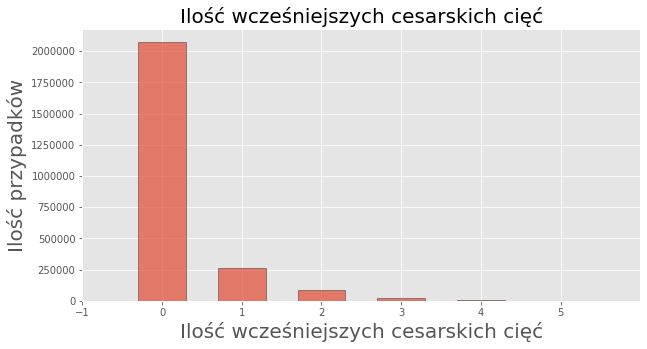

In [152]:
bins = np.arange(-1,6) + 0.5
df.RF_CESARN.plot(kind='hist', edgecolor='black',alpha=.7, rwidth=.6, bins=bins, figsize = (10,5))
plt.title('Ilość wcześniejszych cesarskich cięć', size=20)
plt.xlabel('Ilość wcześniejszych cesarskich cięć', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((-1, 6))
plt.xticks(bins - 0.5);

**SEX** - płeć noworodka.<br>
**Wartości:**<br>
0 - męska,<br>
1 - żeńska.<br>

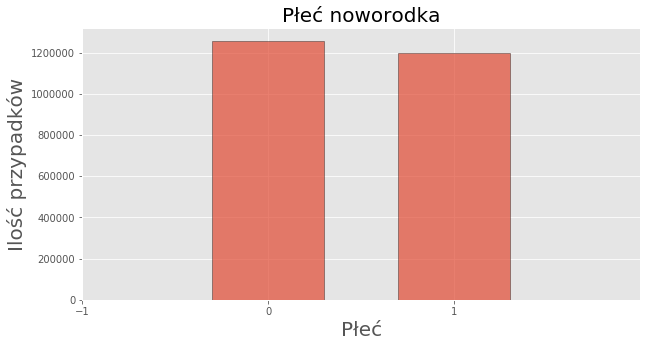

In [153]:
bins = np.arange(-1,2) + 0.5
df.SEX.plot(kind='hist', edgecolor='black',alpha=.7, rwidth=.6, bins=bins, figsize = (10,5))
plt.title('Płeć noworodka', size=20)
plt.xlabel('Płeć', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((-1, 2))
plt.xticks(bins - 0.5);

**WTGAIN** - przybrana waga w funtach.<br>
**Wartości:** [0, 98]<br>
99 - nieznane.

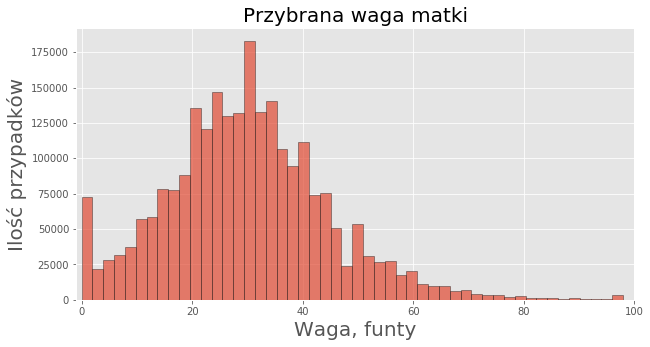

In [154]:
df.WTGAIN.plot(kind='hist', edgecolor='black',alpha=.7, rwidth=1, bins=50, figsize = (10,5))
plt.title('Przybrana waga matki', size=20)
plt.xlabel('Waga, funty', size=20)
plt.ylabel('Ilość przypadków', size=20)
plt.xlim((-1, 100));

Chciałem też uprościć jedną z kolumn, która przechowuje wyniki, które chciałbym przewidzieć. Dotyczy ona
sposobu w jaki urodziło się dziecko. W tym przypadku nie interesowały mnie szczegóły lecz generalna konkluzja,
dlatego też uogólniłem kilka możliwych wyników do zaledwie dwóch przypadków.

In [155]:
output_list = []
for item in df['RDMETH_REC'].values:
    if item in [1, 2, 5]:
        output_list.append(1)
    else:
        output_list.append(2)

Ostateczne przygotowanie data frame. Tutaj składam wcześniej przygotowane kolumny w całość.

In [156]:
output_list = np.array(output_list).astype(np.uint8)
df = df.drop(['RDMETH_REC'], axis=1)
df.insert(24, 'RDMETH_REC', output_list)
column_list = ['BMI', 'CIG_0', 'FAGECOMB', 'FRACE6', 'MAGER', 'MRAVE6', 'NO_RISKS',
               'PRECARE', 'PREVIS', 'PRIORDEAD', 'PRIORLIVE', 'RF_CESARN', 'RDMETH_REC']
df = df[column_list]

## Przewidywanie metody narodzin dziecka za pomocą drzew decyzyjnych i redukcji wymiarów

Do zbadania tego problemu wykorzystam następujące kolumny:
1. BMI matki.
2. Ilość dziennie wypalonych papierosów przed ciążą.
3. Wiek ojca.
4. Rasa ojca.
5. Wiek matki.
6. Rasa matki.
7. Zagrożenie ciąży.
8. Numer miesiąca, w którym rozpoczęła się opieka prenatalna.
9. Ilość wizty prenatalnych.
10. Ilość dzieci z poprzednich ciąż teraz martwych.
11. Ilość dzieci z poprzednich ciąż wciąż żywych.
12. Ilość poprzednich cesarskich cięć.
13. Metoda porodu dziecka.
Gdzie kolumny od 1 do 12 to argumenty, na których podstawie chciałbym przewidzieć wynik przechowywany w kolumnie nr 13.

Tak prezentuje się zbiór danych, który wykorzystam do badania.

In [157]:
df.head()

,BMI,CIG_0,FAGECOMB,FRACE6,MAGER,MRAVE6,NO_RISKS,PRECARE,PREVIS,PRIORDEAD,PRIORLIVE,RF_CESARN,RDMETH_REC
0,30.700001,0,31,1,30,1,1,3,8,0,1,0,1
2,30.000000,0,31,1,28,1,0,5,17,0,1,0,1
3,23.700001,0,26,3,23,3,1,5,6,0,2,0,1
5,31.299999,0,28,1,26,1,1,2,13,0,1,0,1
6,23.000000,0,25,1,28,1,1,3,6,0,2,0,1


Import potrzebnych bibliotek

In [158]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler

Po przygotowaniu zbioru danych, mogę go podzielić na zbiór treningowy oraz testowy w proporcji 70%/30%.
Sprawdzałem kilka możliwości, ale taki stosunek wydaje się być najbardziej odpowiedni.

In [159]:
y = df.pop('RDMETH_REC')
y = y.to_numpy()
X = df.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Mogę w końcu wytrenować model drzewa decyzyjnego. Aby jak najlepiej dobrać parametry, sprawdziłem najpierw,
jaka głębokość drzewa będzie najlepsza dla mojego przypadku.

In [160]:
get_depths, scores_test, scores_train = [], [], []
depths = np.arange(2, 27, 3)

In [161]:
for depth in depths:
    classifier = tree.DecisionTreeClassifier(random_state=0,
                                             max_depth=depth)
    classifier.fit(X_train, y_train)
    get_depths.append(classifier.get_depth())
    scores_test.append(classifier.score(X_test, y_test))
    scores_train.append(classifier.score(X_train, y_train))
get_depths = np.array(get_depths)
scores_test = np.array(scores_test)
scores_train = np.array(scores_train)
depth_score_combined = list(zip(scores_test, get_depths))
x_coord = max(depth_score_combined, key=lambda item:item[0])[1]
y_cord = np.max(scores_test)

Wyniki przedstawię na wykresie:

Najlepsze dopasowanie dla zbioru testowego: 8, 0.7968528292356386


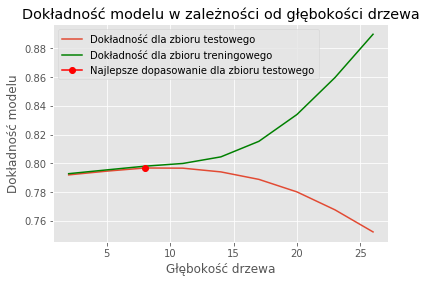

In [162]:
fig, ax = plt.subplots()
ax.plot(get_depths, scores_test, label='Dokładność dla zbioru testowego')
ax.plot(get_depths, scores_train, color='green', label='Dokładność dla zbioru treningowego')
ax.plot(x_coord, y_cord, marker='o', color='red', label='Najlepsze dopasowanie dla zbioru testowego')
ax.set_title('Dokładność modelu w zależności od głębokości drzewa')
ax.set_xlabel('Głębokość drzewa')
ax.set_ylabel('Dokładność modelu')
ax.legend(loc = 'best');
print('Najlepsze dopasowanie dla zbioru testowego: {}, {}'.format(x_coord, y_cord))

In [163]:
print(f'Na wykresie można zobaczyć, że najlepiej radzi sobie model z głębokością drzewa równą {x_coord}.\nPóźniej model ulega przetrenowaniu i zbyt mocno generalizuje wyniki.')

Na wykresie można zobaczyć, że najlepiej radzi sobie model z głębokością drzewa równą 8.
Później model ulega przetrenowaniu i zbyt mocno generalizuje wyniki.


Stworzenie modelu drzewa decyzyjnego oraz trening na zbiorze.

In [164]:
tree_classifier = tree.DecisionTreeClassifier(random_state=0, max_depth=8).fit(X_train, y_train)

Możemy sprawdzić jak dobrze poradził sobie model

In [165]:
result_train = tree_classifier.score(X_train, y_train)
result_test = tree_classifier.score(X_test, y_test)
print(f'Dokładność zbiory treningowego: {result_train}')
print(f'Dokładność zbioru testowego: {result_test}')

Dokładność zbiory treningowego: 0.7980931442693946
Dokładność zbioru testowego: 0.7968528292356386


Model osiągnął 80% dokładności. Być może nie jest to imponująca wartość, ale mówi nam, że na pewno istnieje 
jakaś korelacja między wybranymi argumentami a wynikiem końcowym.

Teraz chciałbym sprawdzić czy redukcja wymiaru może poprawić dokładność wcześniej wytrenowanego modelu. W tym
celu wykorzystam metodę PCA czyli analizę składowych głównych. Na samym początku chciałbym sprawdzić jak wygląda maceierz korelacji dla wybranych przeze mnie zmiennych.

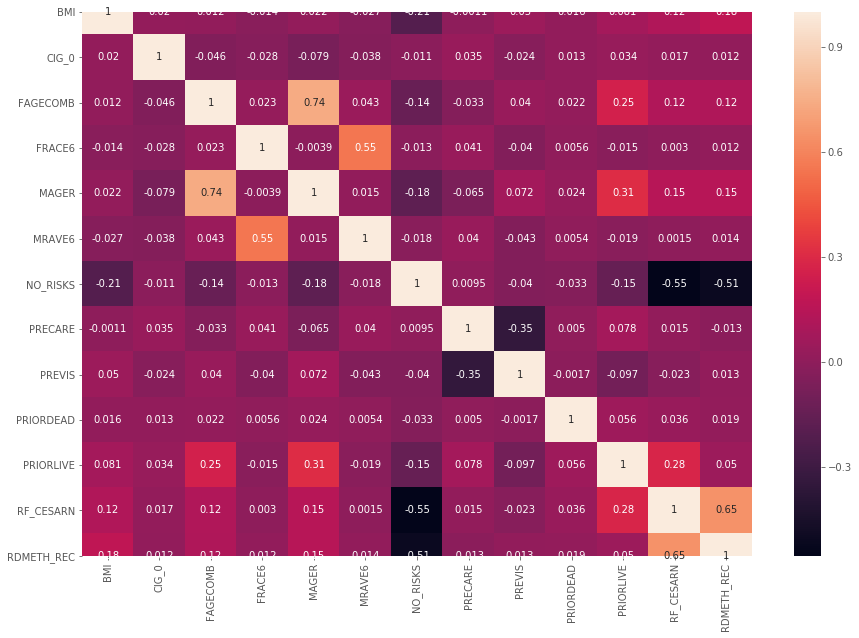

In [166]:
df['RDMETH_REC'] = data['RDMETH_REC']

import seaborn
correlation_matrix = df.corr()
plt.figure(figsize = (15,10))
seaborn.heatmap(correlation_matrix, annot=True)
plt.show()

Nie wszystkie zmienne są skorelowany w sposób istotny, a po wykresie można stwierdzić, że istotny wpływ na metodę porodu dziecka mają wyłącznie zmienne reprezentujące zagrożenie ciąży oraz ilość cesarkich cięć, które do tej pory przeszła matka. Bardzo niewielki wpływ mają również wiek rodziców oraz BMI matki. Do metody PCA powinniśmy wybrać wyłącznie zmienne z istotnym poziomem skorelowania, dlatego też ograniczyłem wykorzystaną liczbę zmiennych.

In [167]:
column_list = ['RF_CESARN', 'NO_RISKS', 'MAGER', 'BMI', 'FAGECOMB', 'RDMETH_REC']
df = df[column_list]

Ponownie podzieliłem zbiór na zbiór treningowy oraz testowy.

In [168]:
y = df.pop('RDMETH_REC')
y = y.to_numpy()
X = df.to_numpy()
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X, y, test_size=0.3)

Należy również sprawdzić jakiej głębokości drzewo będzie odpowiednie dla nowego zestawu danych.

In [169]:
get_depths, scores_test, scores_train = [], [], []
depths = np.arange(2, 27, 3)

In [170]:
for depth in depths:
    classifier = tree.DecisionTreeClassifier(random_state=0,
                                             max_depth=depth)
    classifier.fit(X_train_pca, y_train_pca)
    get_depths.append(classifier.get_depth())
    scores_test.append(classifier.score(X_test_pca, y_test_pca))
    scores_train.append(classifier.score(X_train_pca, y_train_pca))
get_depths = np.array(get_depths)
scores_test = np.array(scores_test)
scores_train = np.array(scores_train)
depth_score_combined = list(zip(scores_test, get_depths))
x_coord = max(depth_score_combined, key=lambda item:item[0])[1]
y_cord = np.max(scores_test)

Teraz już bez wykresu od razu przedstawię wyniki.

In [171]:
print('Najlepsze dopasowanie dla zbioru testowego: {}, {}'.format(x_coord, y_cord))

Najlepsze dopasowanie dla zbioru testowego: 8, 0.7929694448253902


W końcu mogę stworzyć nowy model drzewa decyzyjnego i wytrenować go na zbiorze treningowym.

In [172]:
tree_classifier = tree.DecisionTreeClassifier(random_state=0, max_depth=x_coord).fit(X_train_pca, y_train_pca)

Wyniki osiągnięte przez drzewo prezentują się następująco.

In [173]:
result_train = tree_classifier.score(X_train_pca, y_train_pca)
result_test = tree_classifier.score(X_test_pca, y_test_pca)
print(f'Dokładność zbiory treningowego: {result_train}')
print(f'Dokładność zbioru testowego: {result_test}')

Dokładność zbiory treningowego: 0.7930082732446051
Dokładność zbioru testowego: 0.7929694448253902


Wyniki są prawie identyczne z tymi sprzed wybraniem nowego zestawu zmiennych, które są ze sobą skorelowane. Ręcznie zredukowałem liczbę zmiennych branych pod uwagę przy treningu modelu, ale chciałbym jeszcze sprawdzić czy wykorzystanie metody PCA może cokolwiek zmienić.

In [174]:
in_pca = IncrementalPCA(batch_size=20)
X_pca = in_pca.fit(X_train_pca)

Aby zobaczyć ile składowych głównych powinniśmy wybrać, możemy skorzystać z poniższych właściwości klasy
IncrementalPCA. Pierwsza tablica pokazuje jaką część zmienności danych wyjaśnia każdy argument. W drugiej
tablicy są przechowywane wartości, które mówią jaki % zmienności wyjściowego modelu wyjaśnia kolejne n składowych.

In [175]:
explained_variance = in_pca.explained_variance_ratio_
print(explained_variance)
total_sum = np.cumsum(in_pca.explained_variance_ratio_)
print(total_sum)

[0.54745875 0.3707455  0.07754222 0.00332813 0.0009254 ]
[0.54745875 0.91820425 0.99574646 0.9990746  1.        ]


Możemy też skorzystać z graficznej metody czyli tak zwanego wykresu osypiska. Miejsce załamania wykresu mówi nam
ile składowych powinniśmy wybrać.

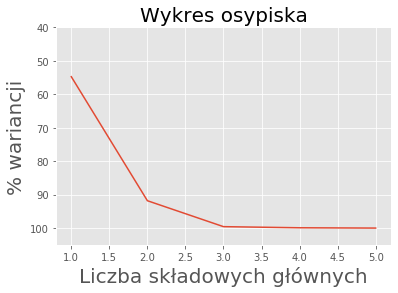

In [176]:
arguments = np.arange(1, X[0].size + 1)
fig, ax = plt.subplots()
ax.plot(arguments, total_sum * 100)
ax.set_title('Wykres osypiska', size = 20)
ax.set_ylim(105, 40)
ax.set_xlabel('Liczba składowych głównych', size = 20)
ax.set_ylabel('% wariancji', size = 20);

Na wykresie wyraźnie widać moment załamania, możemy z niego wywnioskować, że powinniśmy wybrać 2 lub
maksymalnie 3 składowe.

Wiem już ile składowych powinien wykorzystywać model drzewa decyzyjnego. Teraz mogę zredukować wymiar składowych
i sprawdzić jak poradzi sobie model drzewa. Dodatkowo skorzystam z metod standaryzacji danych, które również mogą poprawić wyniki.

In [177]:
train_PCA = StandardScaler().fit_transform(X_train_pca)
test_PCA = StandardScaler().fit_transform(X_test_pca)

in_pca = IncrementalPCA(batch_size=20, n_components=3)
principal_components = in_pca.fit_transform(train_PCA)
test_PCA = in_pca.transform(test_PCA)
tree_classifier.fit(principal_components, y_train_pca)
result_train_PCA = tree_classifier.score(principal_components, y_train_pca)
result_test_PCA = tree_classifier.score(test_PCA, y_test_pca)

print(f'Dokładność zbiory treningowego:  {result_train_PCA}')
print(f'Dokładność zbioru testowego: {result_test_PCA}')

Dokładność zbiory treningowego:  0.7923210184173819
Dokładność zbioru testowego: 0.792084141805991


Wyniki mogą być lekko zaskakujące, ale widać, że zredukowanie wymiaru zbioru nie wpłynęło lub wpłynęło negatywnie 
na dokładność modelu. Może to być spowodowane tym, że metoda PCA całkowice przekształca zbiór danych na odpowiedni
zbiór wektorów, a każda większa zmiana może mieć olbrzymi wpływ na decyzje drzewa.

Ostatnim krokiem będzie sprawdzenie czy model jest w stanie przewidzieć w jaki sposób urodzi się dziecko na
podstawie pewnych informacji.

In [178]:
tree_classifier.fit(X_train, y_train)
child_1 = np.array([30.7, 0, 31, 1, 30, 1, 1, 3, 8, 0, 1, 0]).reshape(1, -1)
child_2 = np.array([33.3, 2, 35, 3, 35, 3, 0, 3, 9, 0, 2, 2]).reshape(1, -1)
print(f'{tree_classifier.predict(child_1)[0]} Dziecko numer 1 urodziły się w naturalny sposób')
print(f'{tree_classifier.predict(child_2)[0]} Dziecko numer 2 urodziło się poprzez cesarskie cięcie')

1 Dziecko numer 1 urodziły się w naturalny sposób
2 Dziecko numer 2 urodziło się poprzez cesarskie cięcie


### Wnioski
    
Model poprawnie rozpoznał dwa podane przypadki. Należy jednak pamiętać, że dokładność modelu wynosi
zaledwie 80%. Istnieje więc dość spore prawdopodobieństwo na błędne przypisanie przypadku do metody porodu.
Na moje potrzeby jest to wynik wystarczający aczkolwiek na pewno dałoby się wykorzystać inne metody, które
dałyby lepsze wyniki.

## Predykcja ryzyka zagrożenia ciąży

In [72]:
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [70]:
df = data.copy()

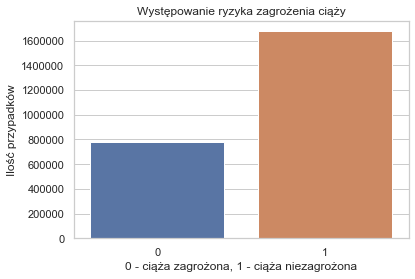

In [73]:
df['NO_RISKS'].value_counts()
sns.countplot(x = 'NO_RISKS', data = df)
plt.title('Występowanie ryzyka zagrożenia ciąży')
plt.xlabel('0 - ciąża zagrożona, 1 - ciąża niezagrożona')
plt.ylabel('Ilość przypadków')
plt.show()

In [74]:
count_no_risks = len(df[df['NO_RISKS']==0])
count_risks = len(df[df['NO_RISKS']==1])
pct_of_no_risks = count_no_risks/(count_no_risks+count_risks)
print("Procent ciąż nie zagrożonych:\t", pct_of_no_risks*100)
pct_of_risks = count_risks/(count_no_risks+count_risks)
print("Procent ciąż zagrożonych:\t", pct_of_risks*100)

Procent ciąż nie zagrożonych:	 31.696703167784296
Procent ciąż zagrożonych:	 68.30329683221571


Jak widać powyżej około 2/3 ciąż jest obarczona ryzykiem zagrożenia. 

Czynniki mogące powodować ryzyko to przede wszytskim cechy fizyczne matki (wzrost, waga), jej wiek ale także stan zdrowia, np. przebyte infekcje lub liczba palonych papierosów dziennie. Sprawdzimy teraz za pomocą wykresów jak wyglądają rozkłady niektórych tych cech.

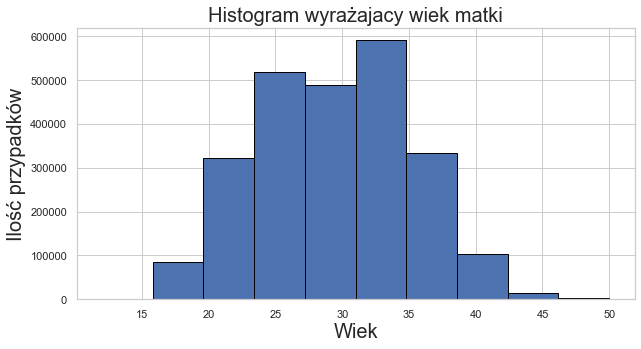

In [91]:
df.MAGER.plot(kind='hist', edgecolor='black', figsize = (10,5))
plt.title('Histogram wyrażajacy wiek matki', size = 20)
plt.xlabel('Wiek', size = 20)
plt.ylabel('Ilość przypadków', size = 20)
plt.show()

Histogram pokazuje, że najwiecej kobiet rodzi dziecko pomiędzy 25 a 35 rokiem życia.

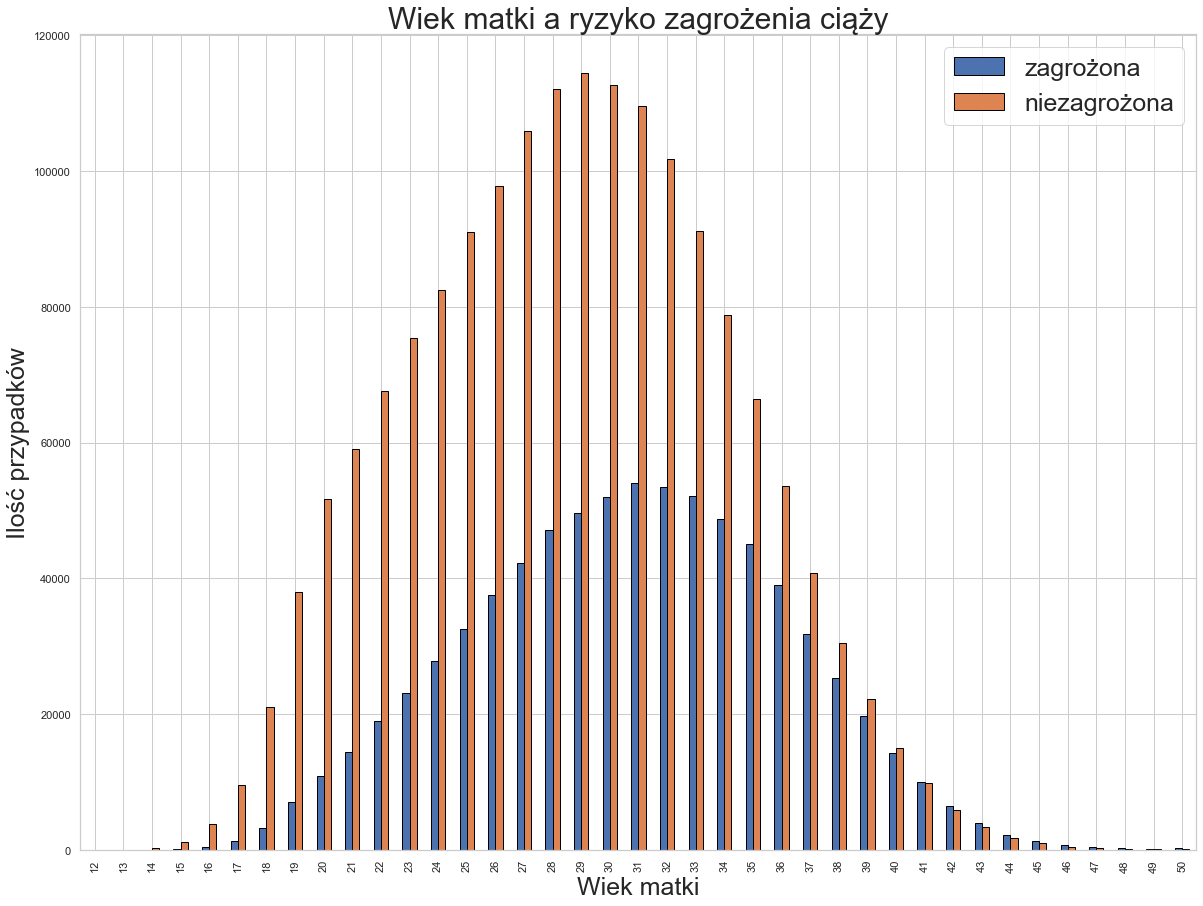

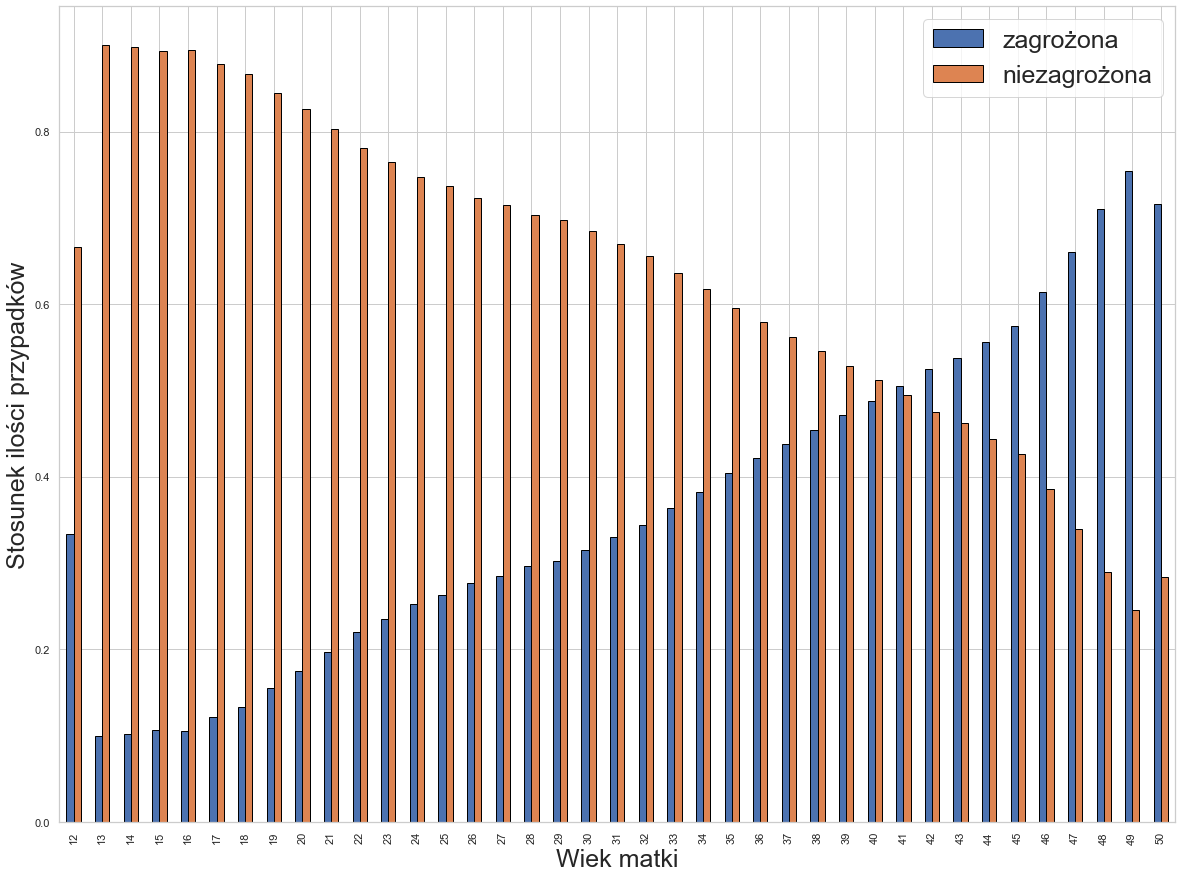

In [92]:
pd.crosstab(df.MAGER,df.NO_RISKS).plot(kind='bar', edgecolor='black', figsize=(20,15))
plt.xlabel('Wiek matki', size = 25)
plt.ylabel('Ilość przypadków', size = 25)
plt.legend(loc='best', fontsize = 25, labels = ['zagrożona','niezagrożona'])
plt.title('Wiek matki a ryzyko zagrożenia ciąży', size = 30)

table=pd.crosstab(df.MAGER,df.NO_RISKS)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', edgecolor='black', figsize=(20,15))
plt.xlabel('Wiek matki', size = 25)
plt.ylabel('Stosunek ilości przypadków', size = 25)
plt.legend(loc='best', fontsize = 25, labels = ['zagrożona','niezagrożona'])
plt.show()

Jak widać w przedziale między 25 a 35 rokiem życia kobiet, a więc w tym samym przedziale gdzie najwiecej kobiet rodzi dzieci, stosunek pomiędzy prawdopodobieństwem wystąpienia ciązy niezagrożonej do zagrożonej wynosi 1 do 2. 

Z wykresu wynika, że wraz z wiekiem rośnie ryzyko zagrożenia ciąży. 

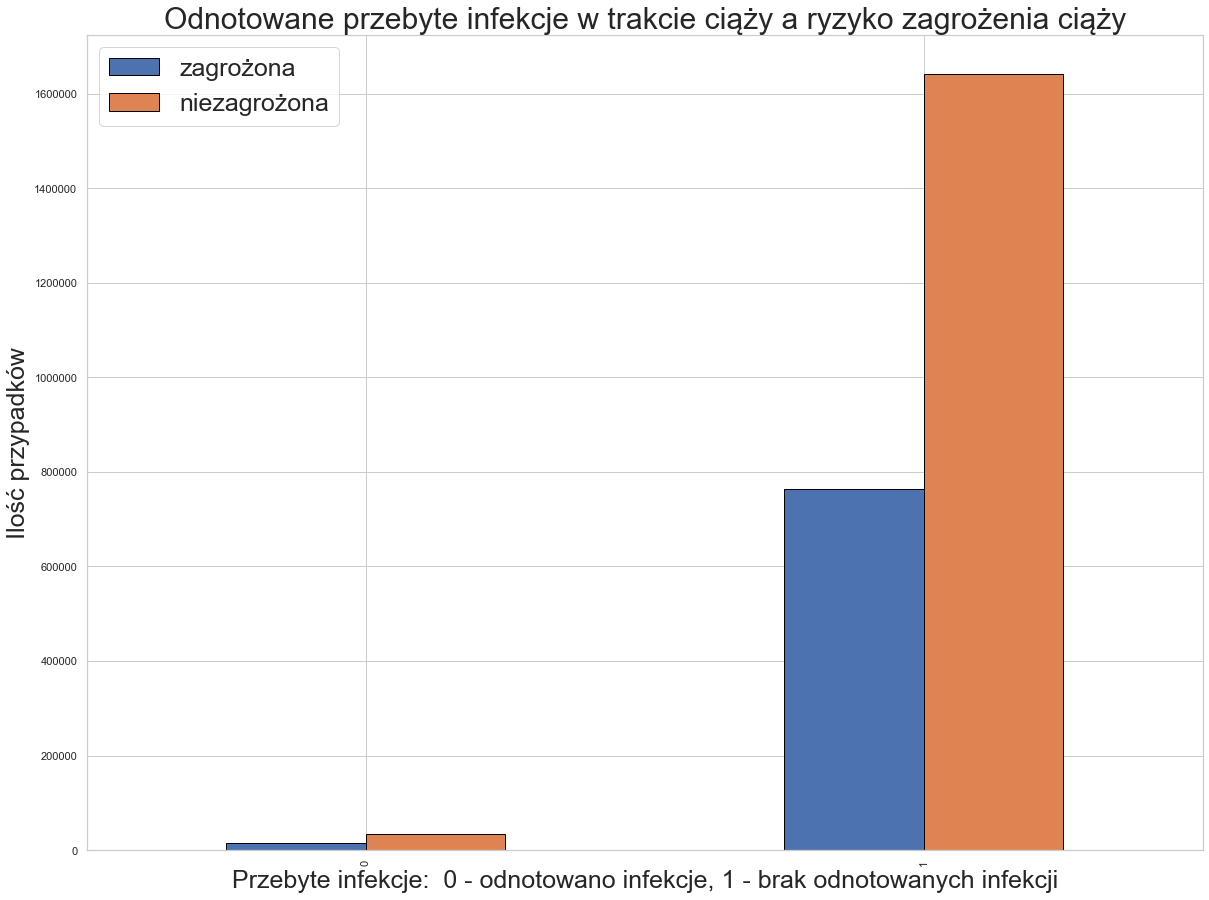

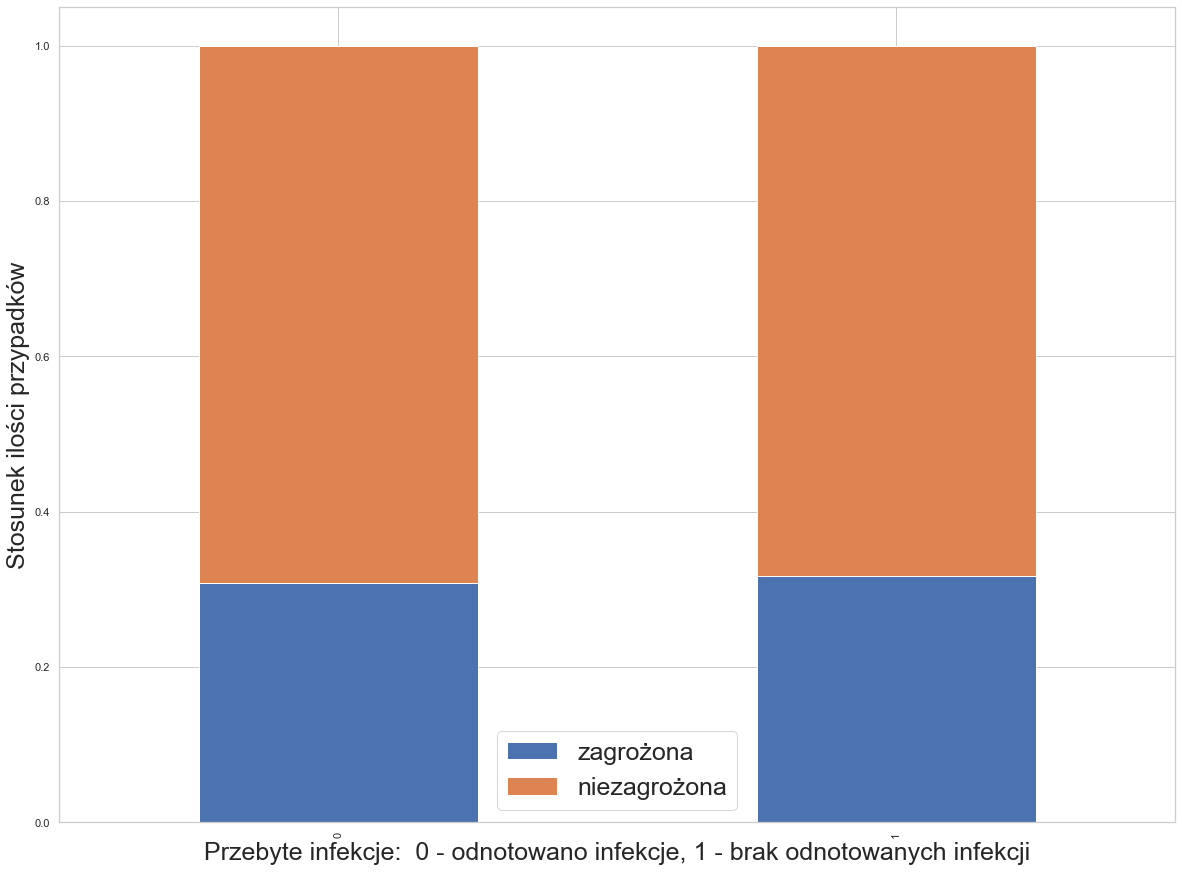

In [101]:
pd.crosstab(df.NO_INFEC,df.NO_RISKS).plot(kind='bar', edgecolor='black', figsize=(20,15))
plt.title('Odnotowane przebyte infekcje w trakcie ciąży a ryzyko zagrożenia ciąży', size = 30)
plt.xlabel('Przebyte infekcje:  0 - odnotowano infekcje, 1 - brak odnotowanych infekcji' , size = 25)
plt.ylabel('Ilość przypadków', size = 25)
plt.legend(loc='best', fontsize = 25, labels = ['zagrożona','niezagrożona'])

table=pd.crosstab(df.NO_INFEC,df.NO_RISKS)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize = (20,15))
plt.xlabel('Przebyte infekcje:  0 - odnotowano infekcje, 1 - brak odnotowanych infekcji' , size = 25)
plt.ylabel('Stosunek ilości przypadków', size = 25)
plt.legend(loc='best', fontsize = 25, labels = ['zagrożona','niezagrożona'])
plt.show()

Z powyższych wykresów wynika, że odnotowane przebyte infekcje nie mają większego znaczenia w przypadku określenia ryzyka zagrożenia ciąży jednak z praktyki wiemy, że ten czynnik jest ważny dlatego weźmiemy go pod uwagę przy tworzeniu modelu.

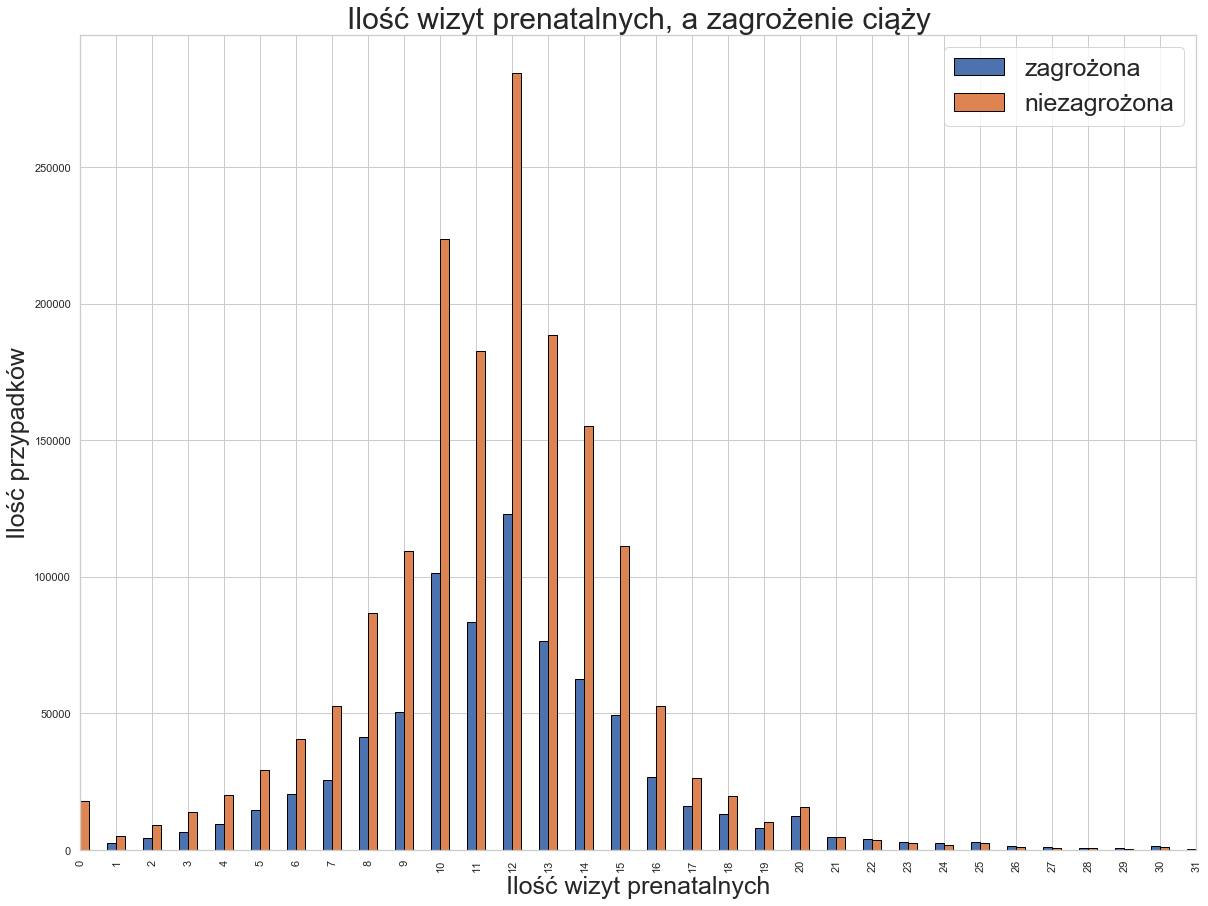

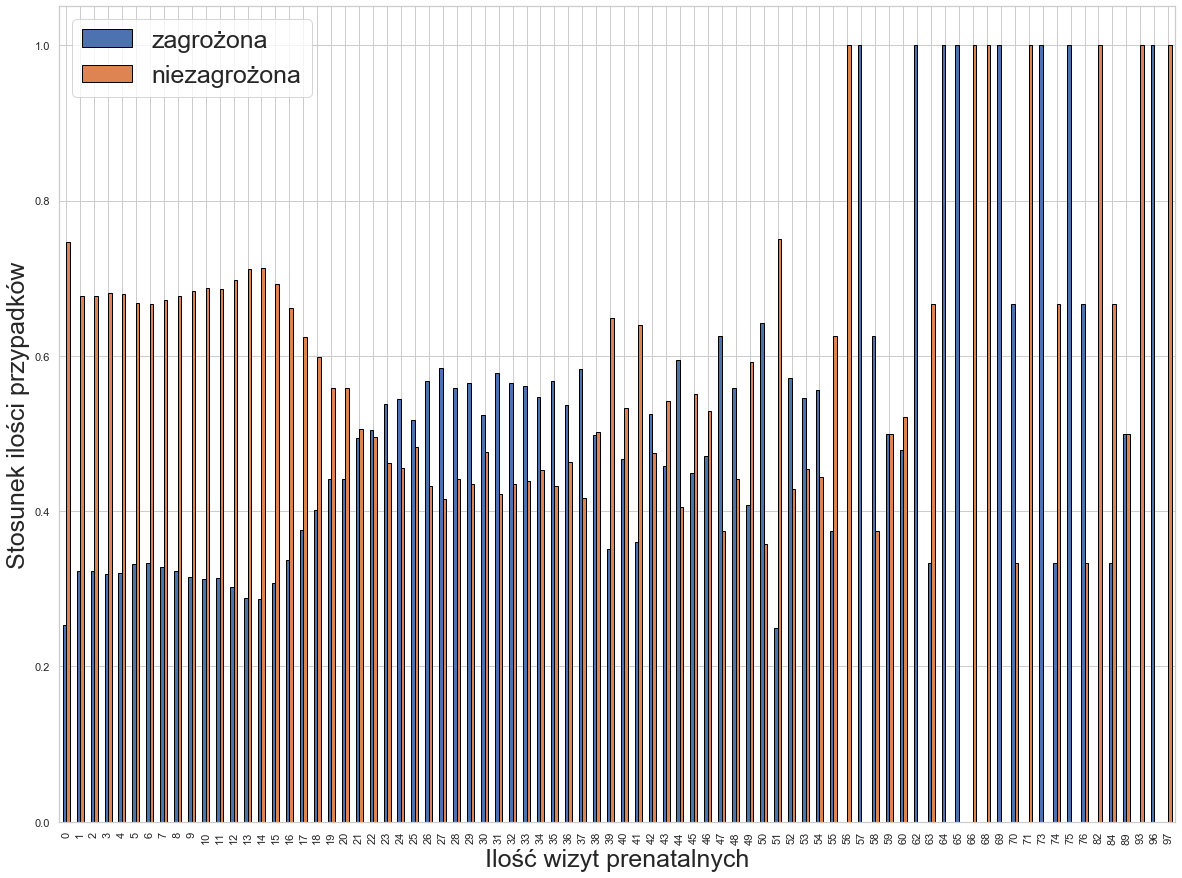

In [103]:
pd.crosstab(df.PREVIS,df.NO_RISKS).plot(kind='bar', edgecolor='black', figsize=(20,15))
plt.title('Ilość wizyt prenatalnych, a zagrożenie ciąży', size = 30)
plt.xlabel('Ilość wizyt prenatalnych', size = 25)
plt.ylabel('Ilość przypadków', size = 25)
plt.xlim(0,31)
plt.legend(loc='best', fontsize = 25, labels = ['zagrożona','niezagrożona'])

table=pd.crosstab(df.PREVIS,df.NO_RISKS)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', edgecolor='black', figsize=(20,15))
plt.xlabel('Ilość wizyt prenatalnych', size = 25)
plt.ylabel('Stosunek ilości przypadków', size = 25)
plt.legend(loc='best', fontsize = 25, labels = ['zagrożona','niezagrożona'])
plt.show()

Jak widać ilość wizyt prenatalnych zmiejsza ryzyko wystąpienia zagrożenia ciąży, jednak na uzyskane wyniki może mieć wyływ stosunkowo mała liczba przypadków, w których liczba takich wizyt jest większa niż 25.
Ponadto prawdopodobnie jeżeli na wczesnym etapie ciąży stwierdza się jej zagrożenie, liczba wizyt prenatalnych zwiększa się co widać na wykresie w postaci dużej liczby takich wizyt dla ciąż zagrozonych.

## Przewidywanie ryzyka zagrożenia ciąży za pomocą regresji logistycznej

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy import stats
import seaborn

In [106]:
def train_logistic_regression(seed, solver_kind, iteration, class_kind,
                              X_train, y_train,
                              X_test, y_test):
    # przygotowanie model regresji logistycznej
    model = LogisticRegression(random_state=seed,
                               solver=solver_kind,
                               max_iter=iteration,
                               multi_class=class_kind).fit(X_train,
                                                           y_train)
    # sprawdzenie dokladności dla zbiowów: treningowego i testowego
    train_accuracy = model.score(X_train, y_train)
    print('Dokładność dla zbioru treningowego:\t {0}.'.format(train_accuracy))
    test_accuracy = model.score(X_test, y_test)
    print('Dokładność dla zbioru testowego:\t {0}.'.format(test_accuracy))
    return model

Przygotowanie danych - wybranie odpowiednich kolumn. 
Sprawdzenie wystąpienia ryzyka zagrożonenia ciąży będzie się opierać o czynniki takie jak:
1. BMI matki
2. Liczba papierosów palonych dziennie przed zajściem w ciążę
3. Status cywilny matki
4. Wiek ojca
5. Wiek matki
6. Wzrost matki
7. Informacja o odnotowanych infekcjach
8. Miesiąc rozpoczęcia opieki prenatalnej
9. Liczba wizyt prenatalnych
10. Waga matki przed rozpoczęciem ciąży
11. Ilość wcześniejszych cesarskich cięć
12. Liczba wcześniej urodzonych dzieci martwych
13. Liczba wcześniej urodzonych dzieci żywych
14. Ocena ryzyka

In [120]:
df = data.copy()
df = df[['BMI', 'CIG_0', 'DMAR', 'FAGECOMB', 'MAGER', 'M_Ht_In','NO_INFEC', 'PRECARE','PREVIS','PWgt_R',  'RF_CESARN', 'PRIORDEAD', 'PRIORLIVE','NO_RISKS']]
df.head()

,BMI,CIG_0,DMAR,FAGECOMB,MAGER,M_Ht_In,NO_INFEC,PRECARE,PREVIS,PWgt_R,RF_CESARN,PRIORDEAD,PRIORLIVE,NO_RISKS
0,30.700001,0,1,31,30,66,1,3,8,190,0,0,1,1
2,30.000000,0,1,31,28,71,1,5,17,215,0,0,1,0
3,23.700001,0,2,26,23,64,1,5,6,138,0,0,2,1
5,31.299999,0,1,28,26,67,1,2,13,200,0,0,1,1
6,23.000000,0,1,25,28,70,1,3,6,160,0,0,2,1


Sprawdzamy korelacje pomiędzy wybranymi czynnikami.

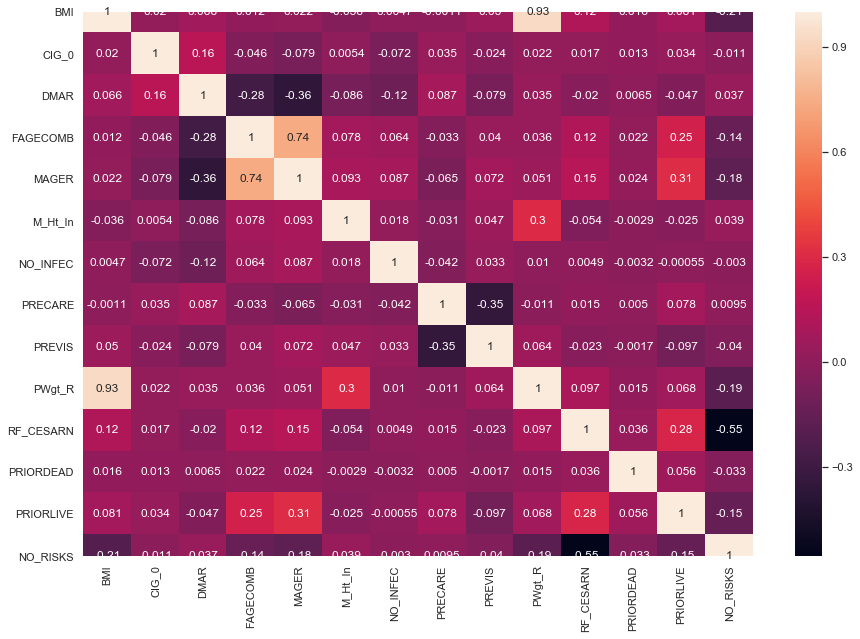

In [126]:
correlation_matrix = df.corr()
plt.figure(figsize = (15,10))
seaborn.heatmap(correlation_matrix, annot=True)
plt.show()

Jak widać 
* waga matki przed porodem (PWgt_R) jest w naturalny sposób skorelowana z BMI
* co ciekawe wiek matki jest skorelowany z wiekiem ojca
* liczba wcześniejszych cięć cesarskich jest ujemnie skorelowana z brakiem występowania ryzyka zagrozenia ciąży

Zmienne niezależne to wszytskie zmienne z tabeli df poza zmienną NO_RISKS, która jest zmienną zależną.

Dane zostały podzielone w stosunku 70% do 30%.

In [127]:
X = df[['BMI', 'CIG_0', 'DMAR', 'FAGECOMB', 'MAGER', 'M_Ht_In','NO_INFEC', 'PRECARE','PREVIS','PWgt_R',  'RF_CESARN', 'PRIORDEAD', 'PRIORLIVE']]
y = df[['NO_RISKS']]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=2)

In [109]:
model = train_logistic_regression(1, 'lbfgs', 500, 'multinomial',
                                      X_train, y_train,
                                      X_test, y_test)

Dokładność dla zbioru treningowego:	 0.8395321080683484.
Dokładność dla zbioru testowego:	 0.8387635086785494.


#### Standaryzacja danych
Zastosujemy standaryzację danych dla poprawy wyników treningu.

Zastosowany wzór:
$$z=\frac{x-u}{s}$$
gdzie
$z$ - próbka po standaryzacji
$x$ - próbka przed standaryzacją
$u$ - średnia całej próbki
$s$ - odchylenie standardowe całej próbki

In [110]:
standarization = preprocessing.StandardScaler().fit(X_train)
X_train_standarized = standarization.transform(X_train)
X_test_standarized = standarization.transform(X_test)

In [112]:
model_after_standarization = train_logistic_regression(1, 'lbfgs', 500, 'multinomial',
                                                           X_train_standarized, y_train,
                                                           X_test_standarized, y_test)

Dokładność dla zbioru treningowego:	 0.8395361815516597.
Dokładność dla zbioru testowego:	 0.838778444772435.


Dzięki standaryzacji zbiorów dokładność nieznacznie się zwiększyła.

## Przewidywanie masy dziecka przy narodzinach za pomocą regresji logistycznej

Celem tej analizy będzie sprawdzenie, czy za pomocą uczenia maszynowego jesteśmy w stanie przewidzieć, czy dziecko w czasie narodzin będzie ważyło poniżej 2500g. Dzieci, które mają masę poniżej 2500g są klasyfikowane jako mające niedowagę, i są narażone na większe ryzyko w przyszłości niż dzieci z prawidłową wagą.

Zaimportujemy niezbędne biblioteki do analizy i wizualizacji danych.

In [179]:
from scipy import stats
import seaborn

Stworzymy kopię głównego dataframe'a, do której zaimportujemy tylko niektóre kolumny.

In [180]:
df = data.copy()
df_m = df[['DLMP_YY', 'DLMP_MM', 'CIG_0', 'BMI', 'DBWT',
           'DWgt_R', 'MAGER', 'M_Ht_In', 'PREVIS', 'PWgt_R',
           'RF_CESARN', 'WTGAIN', 'NO_RISKS', 'NO_INFEC',
           'SEX', 'DOB_MM']].copy()

Zanim zaczniemy analizę, stworzymy dodatkową kolumnę - długość trwania ciąży. Długość ciąży można obliczyć na podstawie dostępnych danych - "DLMP_MM" oraz "DLMP_MM" dotyczących roku i miesiąca ostatniej miesiączki, oraz "DOB_MM" dotyczącej miesiąca urodzenia dziecka.

In [181]:
def gestation(row):
    if row['DLMP_YY'] == 2018:
        return row['DOB_MM'] - row['DLMP_MM']
    if row['DLMP_YY'] == 2017 or row['DLMP_YY'] == 2016:
        return 12 + row['DOB_MM'] - row['DLMP_MM']

Dodajemy kolumnę do DataFrame'a.

In [182]:
df_m['GST_TIME'] = df_m.apply(lambda row: gestation(row), axis=1)

Zwizualizujemy sobie zależność między długością ciąży a wagą dziecka:

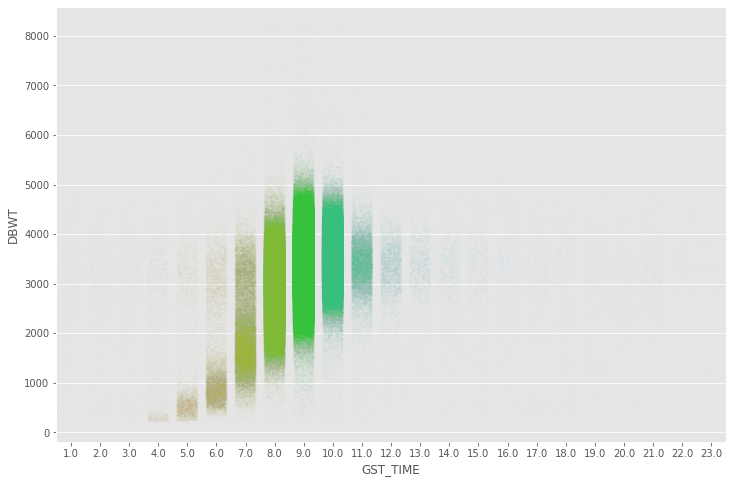

In [183]:
plt.figure(figsize = (12,8))
seaborn.stripplot(x=df_m['GST_TIME'], y=df_m['DBWT'], size=2, alpha=.02, jitter=.35);

Ze względu na błędy we wpisanym roku, usuniemy wszystkie rekordy gdzie czas trwania ciąży wyszedł mniejszy niż 4 lub większy niż 12.

In [184]:
df_m = df_m[(df_m.GST_TIME > 3) & (df_m.GST_TIME < 12)]

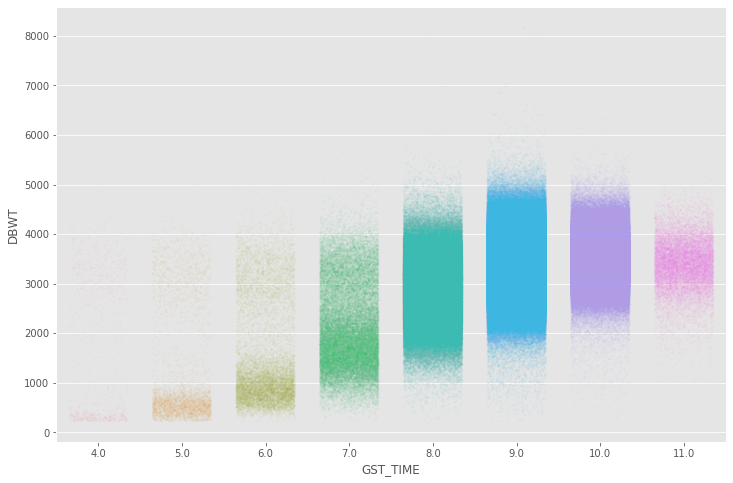

In [185]:
plt.figure(figsize = (12,8))
seaborn.stripplot(x=df_m['GST_TIME'], y=df_m['DBWT'], size=2, alpha=.05, jitter=.35);

Możemy już usunąć kolumny 'DLMP_YY', 'DLMP_MM' oraz 'DOB_MM'.

In [186]:
df_m = df_m.drop(['DLMP_YY', 'DLMP_MM', 'DOB_MM'], axis=1);

Zmienimy również kolumnę CIG_0 tak, aby wyrażała tylko wartości 0 (osoba niepaląca) lub 1 (osoba paląca).

In [187]:
df_m['CIG_0'] = df.CIG_0.apply(lambda x: 0 if x == 0 else 1)

Aby móc wytrenować model regresji logistycznej, muszą być spełnione pewne warunki. Niektóre z nich to:
* binarna regresja logistyczna wymaga, aby zmienna zależna była wartością binarną,
* pomiędzy zmiennymi niezależnymi nie ma dużej współzależności.

Aby sprawdzić, czy między zmiennymi nie ma współzależności, zrobimy macierz korelacji naszych zmiennych.

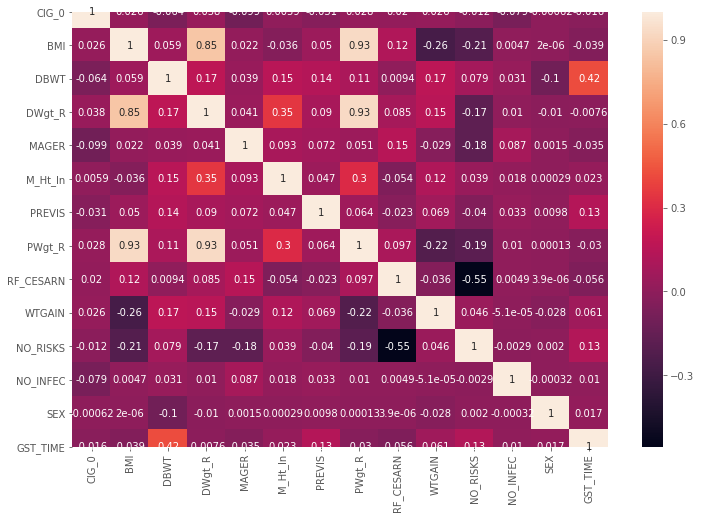

In [188]:
correlation_matrix = df_m.corr()
plt.figure(figsize = (12,8))
seaborn.heatmap(correlation_matrix, annot=True);

Z rysunku powyżej możemy wywnioskować:
* BMI jest silnie powiązane z wagą matki przed ciążą i przed porodem, co oczywiste, jako że BMI jest zależne od wagi matki. W związku z tym z dalszej analizy usuniemy BMI jako zmienną współzależną,
* liczba wcześniejszych cesarskich cięć jest ujemnie skorelowana w stosunku do występujących czynników ryzyka,
* czas trwania ciąży (GST_TIME) jest skorelowany z wagą dziecka.

In [189]:
df_m = df_m.drop("BMI", axis=1);

Aby przewidzieć, czy dziecko będzie ważyło poniżej 2500g, zmienimy wartości w kolumnie 'DBWT' na 0 jeśli dziecko waży powyżej 2500g, oraz na 1 jeśli dziecko waży poniżej 2500g.

In [190]:
df_m['DBWT'] = df.DBWT.apply(lambda x: 0 if x > 2500 else 1)

Aby przyspieszyć czas uczenia, zmniejszymy wymiar danych za pomocą IncrementalPCA. Zrobimy wykres osypiska aby sprawdzić ile zmiennych jest potrzebnych aby wystarczająco wyjaśnić dane. Trzeba jednak wcześniej sprawdzić, które zmienne można zostawić, oceniłem to na podstawie wykresu cieplnego korelacji. Zmienne, które są bardzo słabo skorelowane z resztą zmiennych należy usunąć, dotyczyło to również jednej zmiennej, która była zbyt silnie skorelowana z innymi zmiennymi.

Naszymi zmiennymi niezależnymi są wszystkie zmienne zaimportowane do DataFrame'a df_m za wyjątkiem wagi dziecka (DBWT).

Naszą zmienną zależną, którą chcemy przewidzieć, jest waga dziecka, wyrażona już jako 0 lub 1.

In [191]:
from sklearn.linear_model import LogisticRegression

x = df_m.drop(['DBWT', 'CIG_0', 'DWgt_R', 'PREVIS', 'NO_INFEC', 'SEX'], axis=1)
y = df_m['DBWT']

Dzielimy dane na treningowe oraz testowe w proporcji 7/3.

In [192]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

[0.87418435 0.98044299 0.9961046  0.99951568 0.99974997 0.99994396
 1.        ]


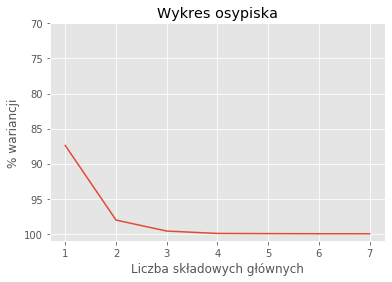

In [197]:
in_pca = IncrementalPCA(batch_size=20)
x_pca = in_pca.fit(x_train)
total_sum = np.cumsum(in_pca.explained_variance_ratio_)
print(total_sum)

arguments = np.arange(1, 8)
fig, ax = plt.subplots()
ax.plot(arguments, total_sum * 100)
ax.set_title('Wykres osypiska')
ax.set_ylim(101, 70)
ax.set_xlabel('Liczba składowych głównych')
ax.set_ylabel('% wariancji');

Wykres się 'wypłaszcza' przy około 3 składowych, więc tyle zostało przyjęte w dalszej analizie.

In [198]:
train_PCA = StandardScaler().fit_transform(x_train)
test_PCA = StandardScaler().fit_transform(x_test)
in_pca = IncrementalPCA(batch_size=20, n_components=3)
principal_components = in_pca.fit_transform(train_PCA)
test_PCA = in_pca.transform(test_PCA)
logreg = LogisticRegression(max_iter=5000)
logreg.fit(principal_components, y_train)

result_train_PCA = logreg.score(principal_components, y_train)
result_test_PCA = logreg.score(test_PCA, y_test)
print(f'Dokładność zbioru treningowego:\t {result_train_PCA}')
print(f'Dokładność zbioru testowego:\t {result_test_PCA}')

Dokładność zbioru treningowego:	 0.9257771211333734
Dokładność zbioru testowego:	 0.9258512856150104


### Wnioski

Otrzymaliśmy dość wysoką dokładność 92.6%. Jest to zadowolająca wysokość.